# Advanced Machine Learning

## Assignment #5

<a href="https://drive.google.com/open?id=1NtIpaYVv_112I4K7AmBg0qIdYQMuIhdS">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width=150 align='left'/>
</a>

### Packages

In [89]:
# Magic trio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform

# For limit outputs
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.facade.smac_ac_facade import SMAC4AC
from smac.optimizer.acquisition import EI, LCB
from smac.configspace import ConfigurationSpace, Configuration
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter
from smac.initial_design.latin_hypercube_design import LHDesign
import pyDOE

In [2]:
dt = pd.read_csv("fertility.csv")

In [3]:
dt.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,Class
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,2
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,2


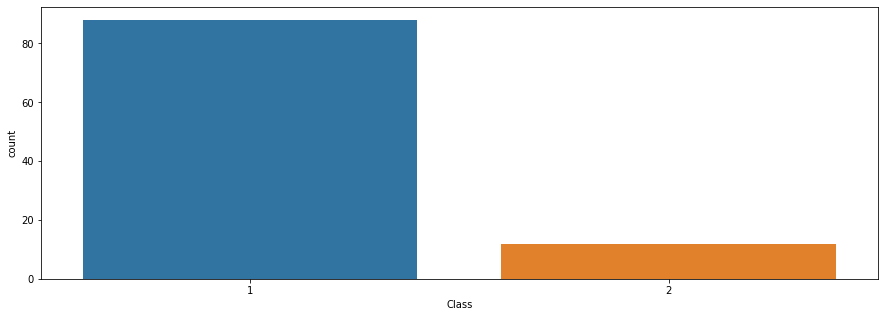

In [4]:
plt.figure(figsize = (15,5))
sns.countplot(dt.Class)

### Preprocessing

In [5]:
dt.Class = dt.Class.map(lambda x: 0 if x == 1 else 1)

In [6]:
Y = np.array(dt.Class)
X = np.array(dt.drop("Class", axis = 1))

### Step 1

In [7]:
# Inizializzo configuration space
cs = ConfigurationSpace()

# Definisco distribuzione degli elementi che voglio ottimizzare
l_rate = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9, default_value = 0.9)

print("Adding parameters to be optimized:")
cs.add_hyperparameters([l_rate, momentum])

Adding parameters to be optimized:


[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.9]

In [8]:
# definisco random sample configuration points su cui valutare entrambi i modelli di ottimizzazione costuriti
# per ottenere questi punti definisco un seed

BIG_SEED = 30112019
#cs.seed(BIG_SEED)
init = cs.sample_configuration(5)
#cs.seed(None)
init

[Configuration:
   learning_rate_init, Value: 0.017979911186950207
   momentum, Value: 0.11781733563117572, Configuration:
   learning_rate_init, Value: 0.05815989732046531
   momentum, Value: 0.34199984857215393, Configuration:
   learning_rate_init, Value: 0.038410183432217394
   momentum, Value: 0.5787248812176046, Configuration:
   learning_rate_init, Value: 0.010100598391586078
   momentum, Value: 0.8952378163004288, Configuration:
   learning_rate_init, Value: 0.013811455791761022
   momentum, Value: 0.19277636197514048]

In [10]:
# Definisco funzione obiettivo, sia MLPCLassifier e Cross-Validation vengono inizializzati con un seme fissato così da
# evitare che i punti iniziali vengano valutati in modo diverso a seconda del modello utilizzato ma anzi vengano valutati
# nello stesso modo

def nn_from_cfg(cfg):
    rseed = int(cfg['momentum']*cfg['learning_rate_init']*5000)
    
    cfg = {k : cfg[k] for k in cfg if cfg[k]}
    
    clf = MLPClassifier(**cfg,
                        hidden_layer_sizes = (4, 2),
                        random_state = rseed)
    
    skf = StratifiedKFold(n_splits = 10, random_state = BIG_SEED)
    scores = cross_val_score(clf, X, Y, cv = skf, scoring = 'accuracy')
    return (1-np.mean(scores))  # Minimizzo errore!

In [11]:
# visualizzo config di default

default_cfg = cs.get_default_configuration()
print("Default config:", default_cfg)

Default config: Configuration:
  learning_rate_init, Value: 0.055
  momentum, Value: 0.9



In [12]:
# Si definisce lo scenario

scenario = Scenario({"run_obj": "quality",   # si ottimizza la misura di valutazione della classificazione
                     "runcount-limit": 24,   # 20 iterazioni più le configuzioni iniziali
                     "cs": cs,               # configuration space
                     "deterministic": "True"})

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-11-30_18:29:52_725010


In [14]:
# Ottimizzazione SMAC con funzione di acquisizione Expeceted Improvement e Modello surrogato Gaussian Process

print("Optimizing! Depending on your machine, this might take a few minutes.")
smac1 = SMAC4BO(scenario = scenario,
                #rng = np.random.RandomState(BIG_SEED),
                tae_runner = nn_from_cfg,
               initial_design = None,
              initial_design_kwargs = {'max_config_fracs': 5/24}, # necessario per fare in modo che vengano valutati
               initial_configurations = init, # solo le configurazioni iniziali impostate prima.
               acquisition_function = EI)

incumbent1 = smac1.optimize()

inc_value1 = nn_from_cfg(incumbent1)
print("Optimized Value: %.2f" % (1-inc_value1))

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Optimizing! Depending on your machine, this might take a few minutes.


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1428) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.017979911186950207 -> 0.05815989732046531
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.11781733563117572 -> 0.34199984857215393
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensif

Optimized Value: 0.89


In [15]:
# Ottimizzazione SMAC con funzione di acquisizione Lower Confidence Bound e Modello surrogato Gaussian Process

print("Optimizing! Depending on your machine, this might take a few minutes.")
smac2 = SMAC4BO(scenario = scenario,
                #rng = np.random.RandomState(BIG_SEED),
                tae_runner = nn_from_cfg,
               initial_design = None,
               initial_design_kwargs = {'max_config_fracs': 5/24},
               initial_configurations = init,
               acquisition_function = LCB)

incumbent2 = smac2.optimize()

inc_value2 = nn_from_cfg(incumbent2)
print("Optimized Value: %.2f" % (1-inc_value2))

INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>


Optimizing! Depending on your machine, this might take a few minutes.


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1428) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.017979911186950207 -> 0.05815989732046531
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.11781733563117572 -> 0.34199984857215393
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1186
INFO:smac.intensification.intensif

Optimized Value: 0.89


In [16]:
maximum = 0.00000001
history_of_maximums = []
maximum2 = 0.00000001
history_of_maximums2 = []

history1 = 1-smac1.get_X_y()[1]

for i in range(len(history1)):
    if history1[i] > maximum:
        maximum = history1[i]
        history_of_maximums.append(maximum)
    else:
        history_of_maximums.append(maximum)  

      
        
history2 = 1-smac2.get_X_y()[1]

for i in range(len(history2)):
    if history2[i] > maximum2:
        maximum2 = history2[i]
        history_of_maximums2.append(maximum2)
    else:
        history_of_maximums2.append(maximum2)

Text(0, 0.5, 'Accuracy')

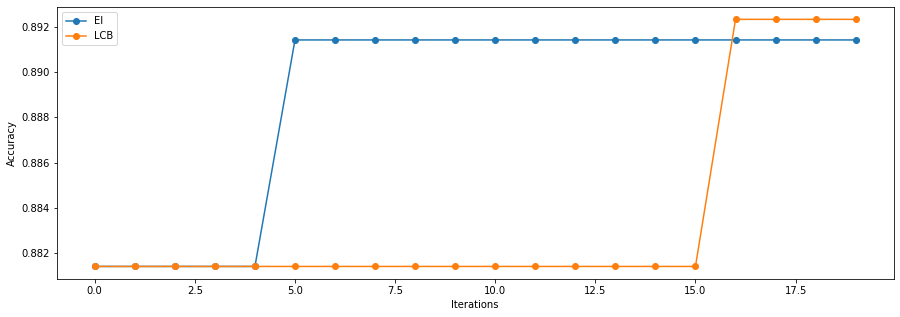

In [17]:
plt.figure(figsize = (15,5))
plt.plot(history_of_maximums[4:], marker = "o")
plt.plot(history_of_maximums2[4:], marker = "o")
plt.legend(["EI", "LCB"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")

Adesso si procede ad effettuare prova con Grid Search Cross-Validation e Random Search Cross-Validation

In [18]:
mlp = MLPClassifier(hidden_layer_sizes = (4,2)#, random_state = int(247.5)
                   )
param_grid = {"learning_rate_init":[0.01, 0.03, 0.06, 0.09, 0.1], "momentum":[0.1, 0.2, 0.4, 0.6, 0.9]}


skf = StratifiedKFold(n_splits = 10, random_state = BIG_SEED)
clf_grid = GridSearchCV(mlp, param_grid, scoring = "accuracy", cv = skf)

clf_grid.fit(X, Y)

print("Best params: {}\nBest score: {}".format(clf_grid.best_params_, clf_grid.best_score_))

Best params: {'learning_rate_init': 0.01, 'momentum': 0.4}
Best score: 0.89


In [19]:
mlp = MLPClassifier(hidden_layer_sizes = (4,2)#, random_state = int(247.5)
                   )

param_distribution = {"learning_rate_init":uniform(0.01, 0.1), "momentum":uniform(0.1, 0.9)}


skf = StratifiedKFold(n_splits = 10, random_state = BIG_SEED)
clf_random = RandomizedSearchCV(mlp, param_distribution, scoring = "accuracy", cv = skf, n_iter = 25)

clf_random.fit(X, Y)

print("Best params: {}\nBest score: {}".format(clf_random.best_params_, clf_random.best_score_))

Best params: {'learning_rate_init': 0.07608293208556602, 'momentum': 0.9089142501378277}
Best score: 0.88


Il random search a parità di iterazioni si avvicina di più al risultato ottenuto dal Gaussian Process, ma risulta più rapido, almeno in questo caso giocattolo.

<hr>

### Step 2

Si ripete quanto fatto utilizzando però il Random Forest come modello surrogato al posto del Gaussian Process, si aumentano il numero di configurazioni iniziali a 10 ed il numero di iterazioni a 100 oltre ad ottimizzare anche il numero di neuroni tra 1 e 5 per ognuno dei 2 layer.

In [62]:
# Inizializzo configuration space
cs = ConfigurationSpace()

# Definisco distribuzione degli elementi che voglio ottimizzare
l_rate = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9, default_value = 0.9)
n_of_neurons1 = UniformIntegerHyperparameter("h1", 1, 5)
n_of_neurons2 = UniformIntegerHyperparameter("h2", 1, 5)

print("Adding parameters to be optimized:")
cs.add_hyperparameters([l_rate, momentum, n_of_neurons1, n_of_neurons2])

Adding parameters to be optimized:


[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.9,
 h1, Type: UniformInteger, Range: [1, 5], Default: 3,
 h2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [79]:
init_rf = cs.sample_configuration(10)
init_rf

[Configuration:
   h1, Value: 3
   h2, Value: 3
   learning_rate_init, Value: 0.025774700189912465
   momentum, Value: 0.8082485185430337, Configuration:
   h1, Value: 4
   h2, Value: 4
   learning_rate_init, Value: 0.07895714278993217
   momentum, Value: 0.4798418658647057, Configuration:
   h1, Value: 2
   h2, Value: 4
   learning_rate_init, Value: 0.0244353187205082
   momentum, Value: 0.10246778496447417, Configuration:
   h1, Value: 5
   h2, Value: 2
   learning_rate_init, Value: 0.084126858996934
   momentum, Value: 0.8419114029159281, Configuration:
   h1, Value: 4
   h2, Value: 1
   learning_rate_init, Value: 0.09423722047300608
   momentum, Value: 0.3074709204657958, Configuration:
   h1, Value: 1
   h2, Value: 3
   learning_rate_init, Value: 0.05637709875041537
   momentum, Value: 0.5052474474786273, Configuration:
   h1, Value: 1
   h2, Value: 2
   learning_rate_init, Value: 0.016368487486914298
   momentum, Value: 0.4679940130193705, Configuration:
   h1, Value: 5
   h2, Va

In [80]:
# Definisco funzione obiettivo

def nn_from_cfg(cfg):
    rseed = int(cfg['momentum']*cfg['learning_rate_init']*5000)
    cfg = {k : cfg[k] for k in cfg if cfg[k]}
    clf = MLPClassifier(
                        hidden_layer_sizes=(cfg["h1"], cfg["h2"]),
                        learning_rate_init = cfg["learning_rate_init"],
                        momentum = cfg["momentum"],
                        random_state = rseed)
    
    skf = StratifiedKFold(n_splits = 10, random_state = BIG_SEED)
    scores = cross_val_score(clf, X, Y, cv = skf, scoring = 'accuracy')
    return (1-np.mean(scores))  # Minimizzo errore!

In [81]:
default_cfg = cs.get_default_configuration()
print("Default config:", default_cfg)

Default config: Configuration:
  h1, Value: 3
  h2, Value: 3
  learning_rate_init, Value: 0.055
  momentum, Value: 0.9



In [82]:
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 109,   # max. number of function evaluations; for this example set to a low number
                     "cs": cs,               # configuration space
                     "deterministic": "true"})

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-11-30_19:07:51_384413


In [83]:
# Utilizzando il Random Forest come modello surrogato e l'Expected Improvement come acquisition function

print("Optimizing! Depending on your machine, this might take a few minutes.")
smac3 = SMAC4HPO(scenario = scenario,
                tae_runner = nn_from_cfg,
               initial_design = None,
               initial_design_kwargs = {'max_config_fracs': 10/109},
               initial_configurations = init_rf,
               acquisition_function = EI)

incumbent3 = smac3.optimize()

inc_value3 = nn_from_cfg(incumbent3)

print("Optimized Value: %.2f" % (1-inc_value3))

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Optimizing! Depending on your machine, this might take a few minutes.


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1206) is better than incumbent (0.1286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 3 -> 2
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 4
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.025774700189912465 -> 0.0244353187205082
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8082485185430337 -> 0.10246778496447417
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1206) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 2 -> 1
INFO:smac.intensification.intensification.Intensifier:  h2 : 4 -> 2
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0244353187205082 -> 0.01636848

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1106
INFO:smac.intensification.in

Optimized Value: 0.89


In [84]:
# Utilizzando il Random Forest come modello surrogato e lower confidence bound come acquisition function

print("Optimizing! Depending on your machine, this might take a few minutes.")
smac4 = SMAC4HPO(scenario = scenario,
                tae_runner = nn_from_cfg,
               initial_design = None,
               initial_design_kwargs = {'max_config_fracs': 10/109},
               initial_configurations = init_rf,
               acquisition_function = LCB)

incumbent4 = smac4.optimize()

inc_value4 = nn_from_cfg(incumbent4)

print("Optimized Value: %.2f" % (1-inc_value4))

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.initial_design.InitialDesign:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>


Optimizing! Depending on your machine, this might take a few minutes.


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1206) is better than incumbent (0.1286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 3 -> 2
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 4
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.025774700189912465 -> 0.0244353187205082
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8082485185430337 -> 0.10246778496447417
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1186) is better than incumbent (0.1206) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 2 -> 1
INFO:smac.intensification.intensification.Intensifier:  h2 : 4 -> 2
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0244353187205082 -> 0.01636848

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1086
INFO:smac.intensification.in

Optimized Value: 0.89


In [85]:
maximum3 = 0.00000001
history_of_maximums3 = []
maximum4 = 0.00000001
history_of_maximums4 = []

history3 = 1-smac3.get_X_y()[1]

for i in range(len(history3)):
    if history3[i] > maximum3:
        maximum3 = history3[i]
        history_of_maximums3.append(maximum3)
    else:
        history_of_maximums3.append(maximum3)  

      
        
history4 = 1-smac4.get_X_y()[1]

for i in range(len(history4)):
    if history4[i] > maximum4:
        maximum4 = history4[i]
        history_of_maximums4.append(maximum4)
    else:
        history_of_maximums4.append(maximum4)

Text(0, 0.5, 'Accuracy')

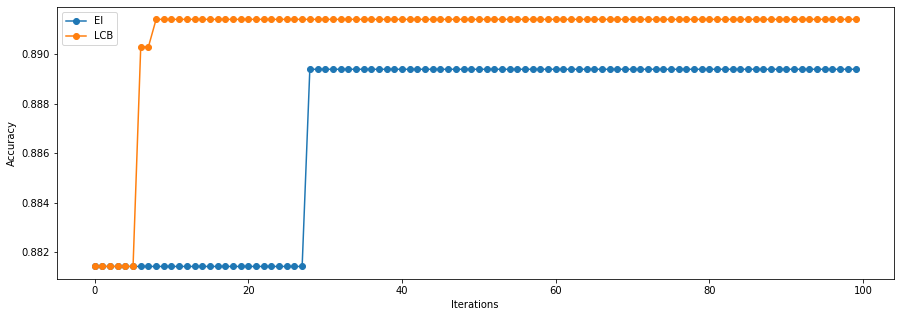

In [86]:
plt.figure(figsize = (15,5))
plt.plot(history_of_maximums3[9:], marker = "o")
plt.plot(history_of_maximums4[9:], marker = "o")
plt.legend(["EI", "LCB"])
plt.xlabel("Iterations")
plt.ylabel("Accuracy")